# RUN THESE CELLS FIRST

## Imports

In [22]:
# Basics
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stats

# Plotting/visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pylab
from mpl_toolkits.mplot3d import Axes3D

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn import metrics


import visualization_helper as vis
import importlib
importlib.reload(vis)

import logging
import sys
logging.basicConfig(stream=sys.stdout)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Hilfsfunktionen

In [3]:
# ANOVA Test
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [4]:
def bootstrap_model(data, callable_model, resamples=100):
    """Collection of bootstrap models fitted according to formula"""
    bootstrap_models = []
    for i in range(resamples):
        resample = data.sample(len(data), replace=True)
        bootstrap_models.append(callable_model(resample).fit())

    return bootstrap_models
        

In [5]:
def bootstrap_gof_poisson():
    pass

In [6]:
def get_bootstrap_spread(fitted_model_coll, x_data, conf_alpha):
    model_predictions = np.array([model.predict(x_data) for model in fitted_model_coll])
    upper = np.array([np.max(model_predictions[:, i]) for i in range(len(x_data))])
    lower = np.array([np.min(model_predictions[:, i]) for i in range(len(x_data))])
    return (lower, upper)

In [7]:
# Helper class for embedding PDF files into notebook
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [8]:
def scatterplot_all(df, target, ncols=3, figsize=(15, 12), alpha=0.1):
    
    # Get all features to plot against target
    features = df.columns.drop(target)

    colors = ['#0055ff', '#ff7000', '#23bf00']
    sns.set_palette(sns.color_palette(colors))

    # Calculate required rows
    nrows = int(np.ceil(len(features) / 3))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=200)

    # Ensure that ax is 2D
    if nrows == 1:
        ax = ax.reshape(-1, 1)

    for i in range(len(features)):
        x = i//ncols
        y = i % ncols

        sns.scatterplot(data=df, x=features[i], y=target, ax=ax[x, y], alpha=alpha)
        ax[x, y].set_title('{} vs. {}'.format(target, features[i]), size=15)
        ax[x, y].set_xlabel(features[i], size=12)
        ax[x, y].set_ylabel(target, size=12)
        ax[x, y].grid()

    return ax

# Aufgabe

In [9]:
PDF("Data_Challenge_Aktuariat.pdf", size=(800, 800))

# Datenexploration und -aufbereitung

## Aufbereitung auf Datenbankebene

Die CSV-Daten werden zunächst zur einfacheren Manipulation
in eine SQLite-Datenbank mit der folgenden Struktur überführt:

``` mysql
CREATE TABLE FREMTPL2FREQ (
    IDpol      INTEGER PRIMARY KEY,
    ClaimNb    INTEGER,
    Exposure   NUMERIC,
    Area       TEXT,
    VehPower   NUMERIC,
    VehAge     INTEGER,
    DrivAge    INTEGER,
    BonusMalus NUMERIC,
    VehBrand   TEXT,
    VehGas     TEXT,
    Density    NUMERIC,
    Region     TEXT
);

CREATE TABLE FREMTPL2SEV (
    IDpol       INTEGER,
    ClaimAmount NUMERIC
);
```

<div class="alert alert-block alert-danger">
<b>Notiz:</b> *Notiz: `FREMTPL2SEV.IDpol` ist weder PRIMARY KEY (nicht eindeutig) noch FOREIGN KEY (es existieren `FREMTPL2SEV.IDpol` ohne zugehörige Police-Merkmale in `FREMTPL2SEV.IDpol`*)
</div>

**Auffälligkeiten:**
1. Es gibt 195 Datensätze in Tabelle ```FREMTPL2SEV```, zu denen keine Tarifmerkmale in ```FREMTPL2FREQ``` vorliegen. Diese sind für die Modellierung wertlos und werden verworfen.
2. Es gibt 9116 Datensätze (von 679513) ~ 1,3%, für die mindestens ein Schadensfall eingetreten ist, allerdings keine Schadenshöhen bekannt sind.
$\Rightarrow$ Interpretation: Datensätze sind nicht fehlerhaft, es fehlt schlicht Information. Die Daten können also für die Modellierung von ClaimNb herangezogen werden, allerdings nicht für ClaimAmount.
``` mysql
SELECT *
FROM FREMTPL2FREQ
LEFT JOIN FREMTPL2SEV
ON FREMTPL2FREQ.IDpol = FREMTPL2SEV.IDpol
WHERE ClaimNb > 1 AND FREMTPL2SEV.IDpol IS NULL
```
    returned 9116 rows

**Weitere Aufbereitung der Daten:**
1. Schadenshöhen für Datensätze mit 0 Schadensfällen werden auf 0 gesetzt
2. Datensätze zu Policen mit mehreren Schadensfällen werden zu einem Datensatz zusammengefasst, in dem sowohl Gesamtschaden ```TotalClaimAmount``` als auch durchschnittlicher Schaden ```AvgClaimAmount``` geführt werden

**Import**

In [10]:
# Connect to SQLite DB
with sqlite3.connect("../raw data/TestDB") as con:

    # SQL query to select fully informative rows (ClaimNb, ClaimAmount, policy data is known)
    qry = """SELECT ClaimNb, Exposure,
    ClaimNb / Exposure AS ClaimFreq,
    Area, VehPower, VehAge, DrivAge, BonusMalus, VehBrand, VehGas, Density, Region,
    SUM(COALESCE(ClaimAmount, 0)) AS TotalClaimAmount,
    AVG(COALESCE(ClaimAmount, 0)) AS AvgClaimAmount
    FROM FREMTPL2FREQ
    LEFT JOIN FREMTPL2SEV
    ON IDpol = IDpol2
    WHERE ClaimNb = 0 OR IDpol2 IS NOT NULL
    GROUP BY IDpol"""

    # Execute SQL query and cast query table into Pandas DataFrame
    df = pd.read_sql_query(qry, con)

In [11]:
df

,ClaimNb,Exposure,ClaimFreq,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,TotalClaimAmount,AvgClaimAmount
0,1,0.75000,1.333333,'F',7,1,61,50,'B12','Regular',27000,'R11',303.00,303.00
1,1,0.14000,7.142857,'B',12,5,50,60,'B12','Diesel',56,'R25',1981.84,1981.84
2,1,0.14000,7.142857,'E',4,0,36,85,'B12','Regular',4792,'R11',1456.55,1456.55
3,2,0.62000,3.225806,'F',10,0,51,100,'B12','Regular',27000,'R11',10834.00,5417.00
4,1,0.31000,3.225806,'A',5,0,45,50,'B12','Regular',12,'R73',3986.67,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668892,0,0.00274,0.000000,'E',4,0,54,50,'B12','Regular',3317,'R93',0.00,0.00
668893,0,0.00274,0.000000,'E',4,0,41,95,'B12','Regular',9850,'R11',0.00,0.00
668894,0,0.00274,0.000000,'D',6,2,45,50,'B12','Diesel',1323,'R82',0.00,0.00
668895,0,0.00274,0.000000,'B',4,0,60,50,'B12','Regular',95,'R26',0.00,0.00


In [12]:
# Discretize some numerical data
# cat_veh_age = pd.cut(df['VehAge'], bins=[0, 2, 10, 25, 100], include_lowest=True, labels=['new', 'mid', 'mid_old', 'old'])
# df.insert(6, "CatVehAge", cat_veh_age, allow_duplicates=False)
# df

## Aufbereitung hinsichtlich ```ClaimNb```

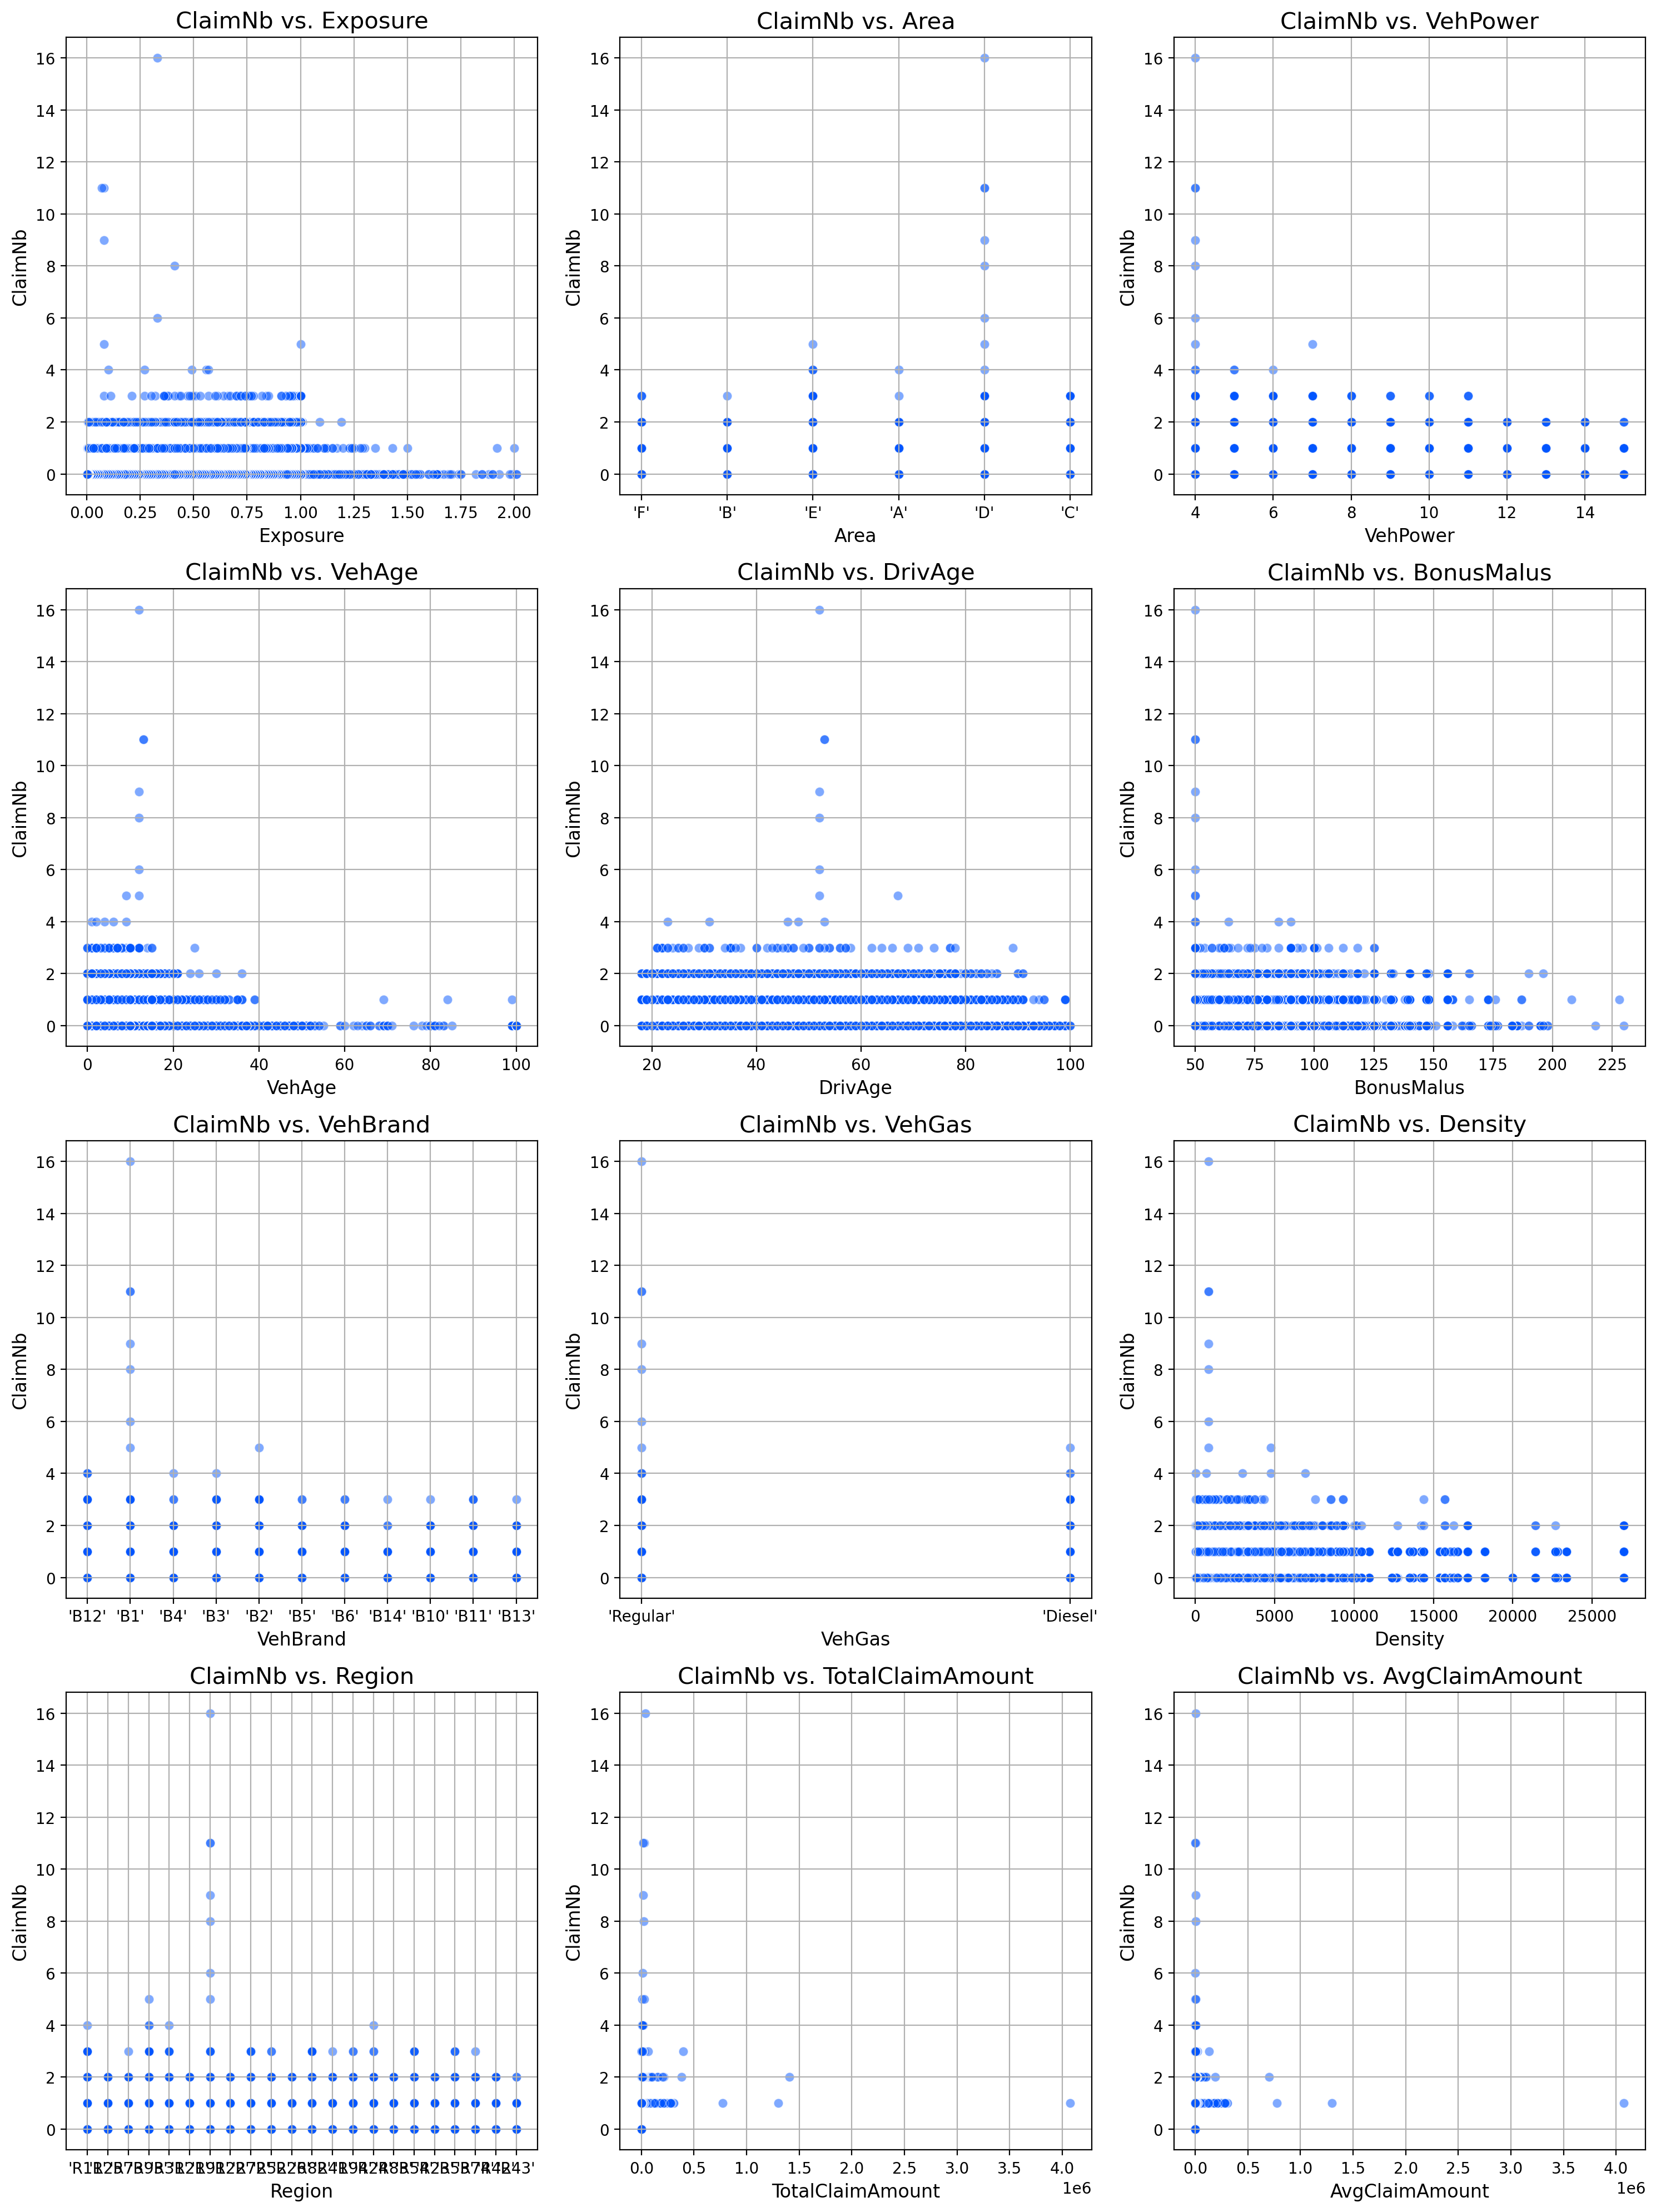

In [13]:
# Opacity
alpha = 0.5

ax = vis.scatterplot_all(df.drop(columns=["ClaimFreq"]), "ClaimNb", figsize=(15, 20), alpha = alpha)
# for elem in ax.flatten(): elem.set_ylim([0, 10])
plt.tight_layout()
plt.show()

**Auffälligkeiten**
1. Es existieren 1224 Datensätze mit ```Exposure > 1``` obwohl es sich eigentlich nur um Jahresdaten handeln soll. Daten sind nicht auffällig und werden behalten.
1. Datensätze mit ```ClaimNb >= 5``` scheinen statistische Anomalien zu sein $\Rightarrow$ Datensätze werden für Modellanpassung nicht verwendet.

In [14]:
df[df["ClaimNb"] >= 5]

,ClaimNb,Exposure,ClaimFreq,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,TotalClaimAmount,AvgClaimAmount
37374,5,1.00,5.000000,'E',7,9,67,50,'B2','Diesel',4762,'R93',6918.10,1383.620000
295374,6,0.33,18.181818,'D',4,12,52,50,'B1','Regular',824,'R91',9653.60,1608.933333
311654,8,0.41,19.512195,'D',4,12,52,50,'B1','Regular',824,'R91',24825.77,3103.221250
312138,16,0.33,48.484848,'D',4,12,52,50,'B1','Regular',824,'R91',35529.37,2220.585625
312402,9,0.08,112.500000,'D',4,12,52,50,'B1','Regular',824,'R91',18354.66,2039.406667
335506,5,0.08,62.500000,'D',4,12,52,50,'B1','Regular',824,'R91',28672.00,5734.400000
478158,11,0.08,137.500000,'D',4,13,53,50,'B1','Regular',824,'R91',25684.42,2334.947273
479160,11,0.07,157.142857,'D',4,13,53,50,'B1','Regular',824,'R91',17587.78,1598.889091


2. Viele Datensätze mit hoher ```ClaimFreq = ClaimNb/Exposure``` kommen von Policen mit niedriger ```Exposure```. Die Wahrscheinlichkeit, dass es sich dabei um gute Schätzungen der wahren (unbeobachteten) Schadensfrequenz handelt, ist gering.

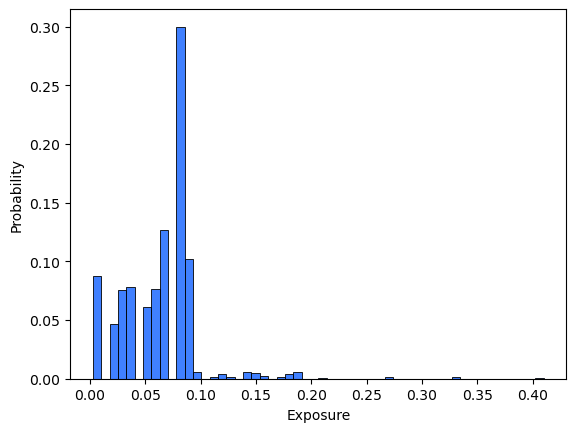

85.0% of all high-frequency claims are filed within the first 30 days


In [15]:
high_freq_data = df[df["ClaimFreq"] > 10]
# Exposure threshold 0.082 corresponds to 30 days
exposure_thresh = 0.082
data_below_thresh = high_freq_data[high_freq_data["Exposure"] < exposure_thresh]
sns.histplot(data=high_freq_data, x="Exposure", stat="probability")
plt.show()
percentage_below_thresh = len(data_below_thresh)/len(high_freq_data) * 100
print("{}% of all high-frequency claims are filed within the first 30 days".format(np.round(percentage_below_thresh)))

Wir sehen auch, dass hohe ```ClaimFreq``` die Realität nicht gut abbilden, wenn wir sie vergleichen mit den **tatsächlichen Schadensfällen** von Kunden mit hoher ```Exposure```.

In [16]:
exposure_thresh = 0.66
max_claimnb = np.max(df[(df["Exposure"] > exposure_thresh)]["ClaimNb"])
print("Max. ClaimNb for clients with exposure > {} is: {}".format(str(exposure_thresh), str(max_claimnb)))

Max. ClaimNb for clients with exposure > 0.66 is: 5


In [17]:
# Conservative (default) approach
conservative_flag = False

# Cutoff for more radical approach
claim_freq_cutoff = 5

# Remove statistical anomalies only
data_claimnb = df[df["ClaimNb"] < 5].copy()
if not conservative_flag:
    # Also remove high-frequency claims above cutoff
    data_claimnb = data_claimnb[data_claimnb["ClaimFreq"] <= claim_freq_cutoff]

## Aufbereitung hinsichtlich ```AvgClaimAmount```

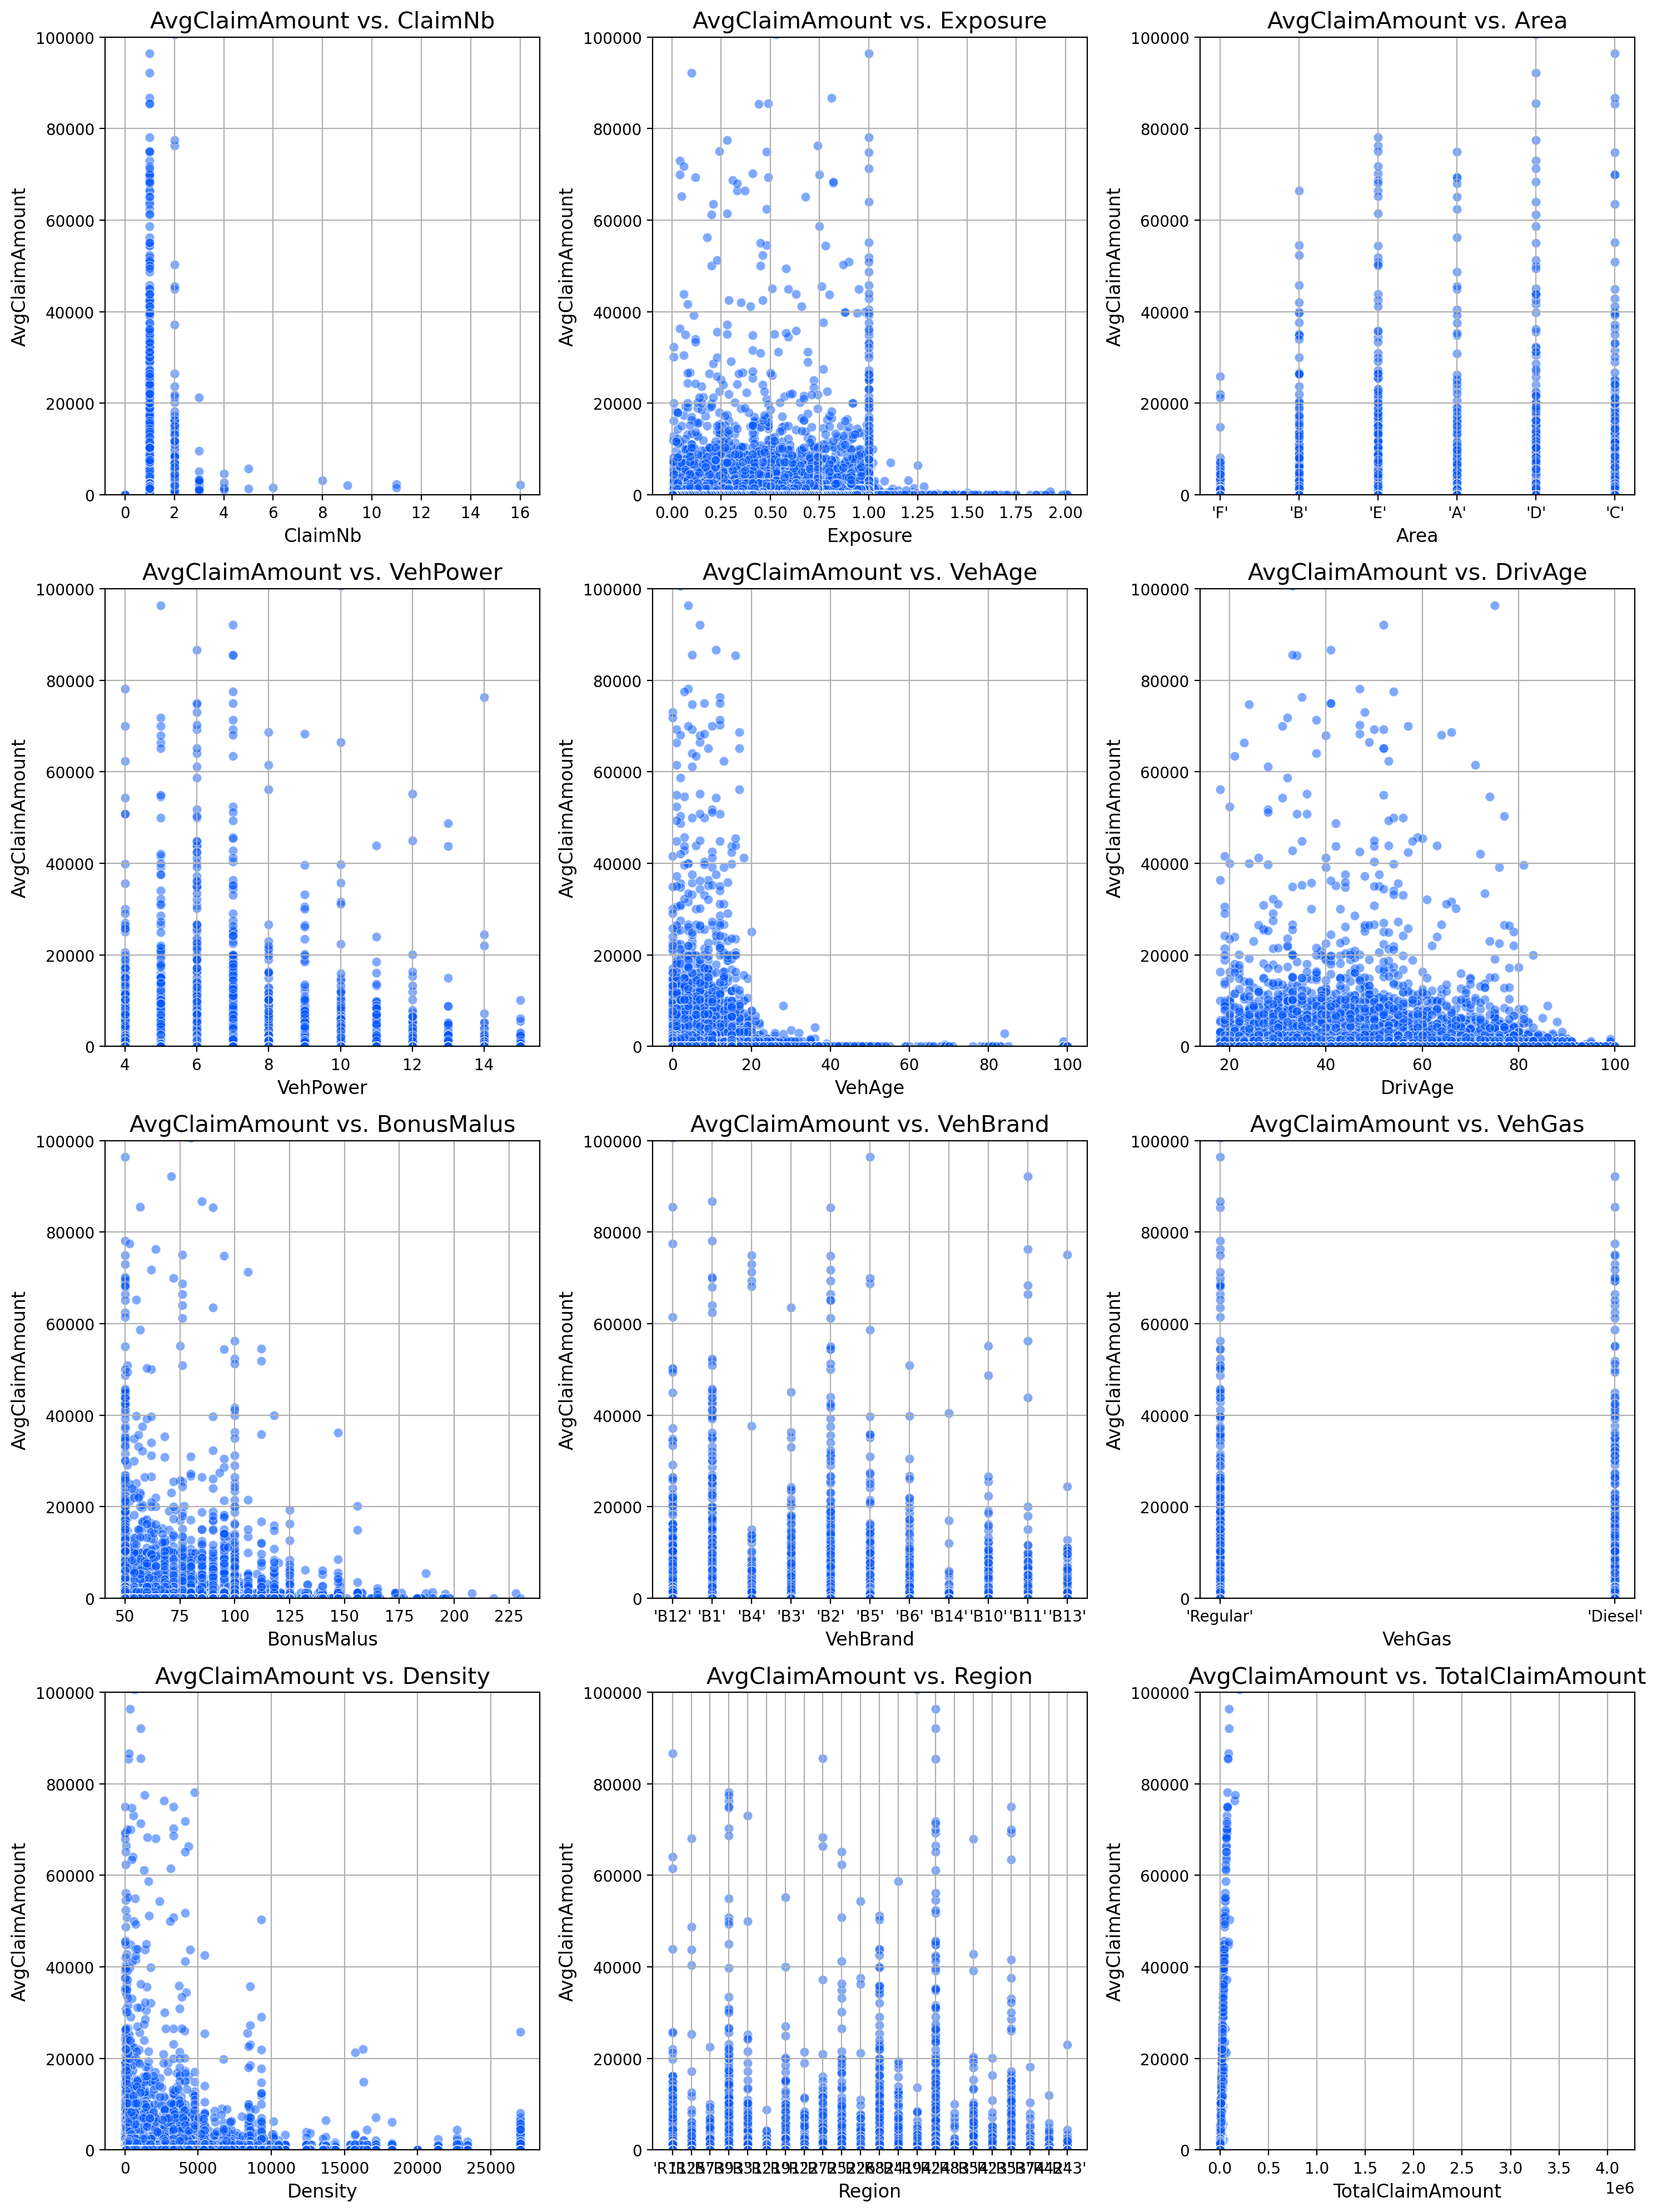

In [17]:
# Opacity
alpha = 0.5

ax = vis.scatterplot_all(df.drop(columns=["ClaimFreq"]), "AvgClaimAmount", figsize=(15, 20), alpha = alpha)
for elem in ax.flatten(): elem.set_ylim([0, 100000])
plt.tight_layout()
plt.show()

Wir behalten ausschließlich Datensätze mit ```AvgClaimAmount > 0```

In [18]:
data_avgclaimsev = data_claimnb[data_claimnb["AvgClaimAmount"] > 0].copy()
data_avgclaimsev

,ClaimNb,Exposure,ClaimFreq,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,TotalClaimAmount,AvgClaimAmount
0,1,0.75,1.333333,'F',7,1,61,50,'B12','Regular',27000,'R11',303.00,303.00
3,2,0.62,3.225806,'F',10,0,51,100,'B12','Regular',27000,'R11',10834.00,5417.00
4,1,0.31,3.225806,'A',5,0,45,50,'B12','Regular',12,'R73',3986.67,3986.67
5,1,0.84,1.190476,'D',10,6,54,50,'B12','Diesel',583,'R93',1840.14,1840.14
6,1,0.75,1.333333,'D',5,0,34,64,'B12','Regular',1565,'R31',1397.97,1397.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667326,1,0.26,3.846154,'C',13,0,48,50,'B12','Regular',171,'R26',1412.40,1412.40
667363,1,0.35,2.857143,'E',6,8,28,60,'B2','Diesel',2252,'R82',576.53,576.53
667738,1,0.22,4.545455,'D',8,3,46,50,'B12','Diesel',721,'R93',10290.00,10290.00
667748,1,0.29,3.448276,'C',4,0,36,57,'B12','Regular',130,'R73',1346.40,1346.40


In [19]:
# Train-test-split
train_claimnb, test_claimnb = train_test_split(data_claimnb, test_size=0.3, random_state=17)
train_avgclaimsev, test_avgclaimsev = train_test_split(data_avgclaimsev, test_size=0.3, random_state=17)

train_claimnb.to_csv('data_claimnb.csv', index=False)
train_avgclaimsev.to_csv('data_avgclaimsev.csv', index=False)

# Feature selection

**Lineare Korrelation von Merkmalen**

In [45]:
num_features = data_claimnb.select_dtypes(include="number") \
    .drop(columns=["Exposure", "ClaimFreq", "AvgClaimAmount"])
cat_features = data_claimnb.select_dtypes(include="object")

In [48]:
print(num_features.corr(method="pearson").round(2))

                  ClaimNb  VehPower  VehAge  DrivAge  BonusMalus  Density  \
ClaimNb              1.00      0.00    0.01     0.00        0.06     0.01   
VehPower             0.00      1.00   -0.01     0.03       -0.08     0.04   
VehAge               0.01     -0.01    1.00    -0.06        0.08    -0.09   
DrivAge              0.00      0.03   -0.06     1.00       -0.48    -0.00   
BonusMalus           0.06     -0.08    0.08    -0.48        1.00     0.08   
Density              0.01      0.04   -0.09    -0.00        0.08     1.00   
TotalClaimAmount     0.07      0.00    0.00    -0.00        0.01    -0.00   

                  TotalClaimAmount  
ClaimNb                       0.07  
VehPower                      0.00  
VehAge                        0.00  
DrivAge                      -0.00  
BonusMalus                    0.01  
Density                      -0.00  
TotalClaimAmount              1.00  


Die Einflüsse der Merkmale auf unsere Zielgrößen sind komplex und nicht-linear

## Intuitive kausale Einflüsse

Intuitiv stärkere Features:
* ```BonusMalus``` beinhaltet Information aus der Vergangenheit (Schadenshistorie)
* ```DrivAge``` beinhaltet Information über Erfahrung des Fahrers und (altersbedingte) gesundheitliche Eignung zum Fahren
* ```VehPower```: Leistung des Fahrzeugs kann Risiko bedeuten, eventuell im Zusammenspiel mit ```DrivAge```
* ```Density```: eine hohe Anzahl Fahrzeuge/Menschen auf geringer Fläche könnten Unfälle begünstigen

<div class="alert alert-block alert-info">
<b>Extra-Bonus durch BonusMalus: moderat positiv korreliert mit ```DrivAge```</b>
</div>

Intuitiv schwache Features:
* ```VehGas```

## Feature selection mit FOCI

Azadkia & Chatterjee's FOCI (**F**eature **O**rdering by **C**onditional **I**ndependence)-Algorithmus
*(Azadkia, M., & Chatterjee, S. (2021). A simple measure of conditional dependence. The Annals of Statistics, 49(6), 3070-3102.)* erlaubt modellunabhängige feature selection (implementiert als R-Paket ```FOCI``` auf CRAN).

Hiermit werden wir für die Zielgrößen ```ClaimNb``` sowie ```AvgClaimAmount``` jeweils a-priori die besten Features auswählen.

```R
library(stats)
library(dplyr)
library(FOCI)
library(rstudioapi)

##################################################
# Little helper script for FOCI feature selection
##################################################

# Number of FOCI runs
n_foci <- 100

# Subsample size
n_subsamp <- 10000

# Getting the directory path of script file
current_path = rstudioapi::getActiveDocumentContext()$path 
setwd(dirname(current_path))

# Import data.frame (Python output)
data <- read.csv("data_claimnb.csv")
# data <- read.csv("data_avgclaimsev.csv")

# Run FOCI on subsamples for n_foci iterations
foci_res <- c()
for (i in 1:n_foci) {
  print(paste("Run: ", i))
  data_subsample <- sample_n(data, n_subsamp, replace = FALSE)
  # Pick response and features
  foci_res <- c(foci_res, foci(data_subsample$ClaimNb, select(data_subsample, BonusMalus, VehPower, DrivAge, VehAge, Density), numCores = 1, num_features=2))
}

# Get list of top features

# Desired rank
rank = 1

top_feature_list <- c()
for (i in 1:n_foci) {
  top_feature <- foci_res[i]$selectedVar[rank]$names
  if (!is.null(top_feature)) {
    top_feature_list <- c(top_feature_list, top_feature)
  }
}

# Count occurrences of each string 
string_counts <- table(top_feature_list) 

# Create a bar plot to help identify top features
barplot(string_counts,  
        main = paste("Frequency of top features, number of FOCI runs:", n_foci),  
        ylab = "Top feature frequency",  
        col = "lightblue",  
        las = 2)  # las=2 makes the axis labels perpendicular to the axis 

```

**Ranking der Features zur Vorhersage von ```ClaimNb``` (R-Output)**

![FOCI result](foci_claimnb_result_fixed.png "FOCI result")

# Modellanpassung

In der (Aktuars-)Literatur (z.B. *Ohlsson, E., Johansson, B., Ohlsson, E., & Johansson, B. (2010). Non-life insurance pricing. Non-Life Insurance Pricing with Generalized Linear Models, 1-14.)* findet man zwei sehr gängige Modellannahmen:
* (Tatsächliche) Schadensfrequenz ist Poisson-verteilt
* Durchschnittliche Schadenshöhe ist Gamma-verteilt

**Es wird zudem angenommen, dass Schadensfrequenz und durchschnittliche Schadenshöhe unabhängig sind**

Basierend hierauf werden wir nun
* ein Poisson-GLM für ```ClaimNb```
* ein Gamma-GLM für ```AvgClaimNb```

anpassen.

Anschließend werden wir untersuchen, ob sich beide Modelle mit einem geeigneten Goodness-of-fit-Test validieren lassen.

Im Abschluss können wir den Gesamtschaden pro Jahr, in Abhängigkeit von den von uns gewählten Features (Kovariaten), vorhersagen und dies zur Tarifkalkulation heranziehen.

## Modellanpassung für ```ClaimNb```

Unsere Zielgröße ist $~~Y \coloneqq \mathrm{ClaimNb}$ (**tatsächliche** Schadensfrequenz (Jahr)) in Abhängigkeit von Kovariaten $\vec{X}=(X_1, \ldots, X_k)$.

Ist $Y$ mit einem Poisson-GLM (mit $\log$ als kanonischer Linkfunktion) verträglich, dann existieren Koeffizienten $\vec{\beta}$, sodass

$$\log(\mathbb{E}(Y\mid \vec{X})) = \vec{\beta}^\intercal\vec{X} = \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k,$$

wobei die Verteilung von $Y$ gegeben einer konkreten Beobachtung $\vec{x} = (x_1, \ldots, x_k)$ einer Poisson-Verteilung mit Parameter $\lambda(\vec{x})$ entspricht. Wir schreiben
$$Y\mid \vec{x} \sim POIS(\lambda(\vec{x}))$$

mit Dichte

$$f_{\lambda(\vec{x})}(y) = \mathbb{P}(Y = y) = \frac{(\lambda(x))^y e^{-\lambda}}{y!}, \qquad y \in \mathbb{N}_0.$$

Eine besondere Eigenschaft der Poisson-Verteilung ist, dass
$\mathbb{E}(Y\mid \vec{X} = x) = \mathrm{Var}(Y\mid \vec{X} = x) = \lambda(x)$

**Eine interessante Beobachtung**

MLE for E(X): 0.03546854837672499, MLE for VAR(X): 0.0378159029295865


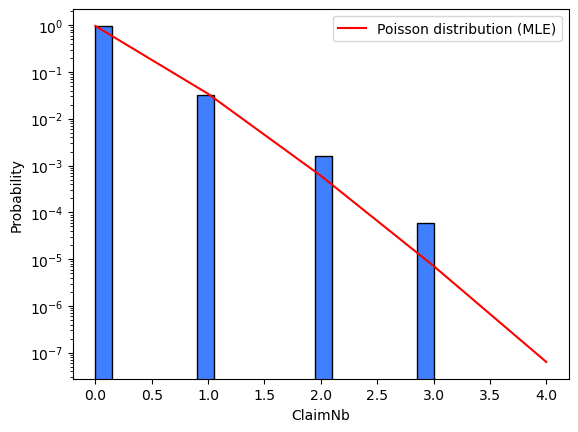

In [20]:
# ClaimNb histogram
sns.histplot(data=train_claimnb, x="ClaimNb", stat="probability")
lambda_mle = np.mean(train_claimnb["ClaimNb"])
poisson_sample = stats.poisson.pmf(np.arange(0, 5), lambda_mle)

# Parametric MLE Poisson reference
poisson_sample_df = pd.DataFrame({'x': np.arange(0, 5), 'y': poisson_sample})
sns.lineplot(data=poisson_sample_df, x="x", y="y", color="red", label='Poisson distribution (MLE)')
ax = plt.gca()
plt.yscale("log")

ax.legend()

print("MLE for E(X): {}, MLE for VAR(X): {}".format(str(lambda_mle), str(np.var(train_claimnb["ClaimNb"]))))

plt.show()

Modellanpassung und -validierung (Log-Linearität und Poisson-ness) mittels Bootstrap Goodness-of-Fit-Test für GLMs in R über Paket ```bootGOF```. Für detaillierte Verfahrensbeschreibung siehe *Dikta und Scheer: B*

TODO: Add R results here

In [22]:
# GLM fit in Python for comparison

formula = "ClaimNb ~ BonusMalus + DrivAge"

glm_poisson = smf.glm(formula=formula, data=train_claimnb, offset=np.log(train_claimnb["Exposure"]), family=sm.families.Poisson())
res_poisson = glm_poisson.fit()


print(res_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               466526
Model:                            GLM   Df Residuals:                   466523
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66205.
Date:                Wed, 02 Oct 2024   Deviance:                   1.0045e+05
Time:                        00:22:19   Pearson chi2:                 4.00e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.006831
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5976      0.046   -100.412      0.0

TODO: Average partial effect here

In [32]:
# GLM "full model" here

formula = "ClaimNb ~ BonusMalus + DrivAge + VehAge + VehPower + Density + C(Area) + C(Region) + C(VehGas)"

glm_poisson = smf.glm(formula=formula, data=train_claimnb, offset=np.log(train_claimnb["Exposure"]), family=sm.families.Poisson())
res_poisson = glm_poisson.fit()


print(res_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               466526
Model:                            GLM   Df Residuals:                   466493
Model Family:                 Poisson   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65830.
Date:                Wed, 02 Oct 2024   Deviance:                       99699.
Time:                        00:30:12   Pearson chi2:                 3.96e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.008428
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

## Modellanpassung für ```AvgClaimAmount```

Beobachte: Wenn ClaimNb = 0, dann muss AvgClaimAmount nicht mehr vorhergesagt werden

Unsere Zielgröße ist $~~Y \coloneqq \mathrm{AvgClaimAmount}$ in Abhängigkeit von Kovariaten $\vec{X}=(X_1, \ldots, X_k)$. Es dürfen ausschließlich positive Werte angenommen werden.

Ist $Y$ mit einem Gamma-GLM (als Link-Funktion verwenden wir wieder $\log$) verträglich, dann existieren Koeffizienten $\vec{\beta}$, sodass

$$log(\mathbb{E}(Y\mid \vec{X})) = \vec{\beta}^\intercal\vec{X} = \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k,$$

wobei die Verteilung von $Y$ gegeben einer konkreten Beobachtung $\vec{x} = (x_1, \ldots, x_k)$ einer Gamma-Verteilung mit Parametern $(\alpha(\vec{x}), \beta((\vec{x}))$ entspricht. Wir schreiben
$$Y\mid \vec{x} \sim \Gamma(\alpha(\vec{x}), \beta((\vec{x}))$$

mit Dichte

$$f_{\alpha(\vec{x}), \beta((\vec{x})}(y) = \frac{y^{\alpha(\vec{x}) - 1} e^{-\beta(\vec{x})y}\beta(\vec{x})^{\alpha(\vec{x})}}{\Gamma(\alpha(\vec{x}))}, \qquad y > 0.$$

In [41]:
# GLM fit in Python for comparison

formula = "AvgClaimAmount ~ BonusMalus + DrivAge"
glm_gamma = smf.glm(formula=formula, data=train_avgclaimsev, family=sm.families.Gamma(link=sm.families.links.Log()))

res_gamma = glm_gamma.fit()
print(res_gamma.summary())

#y_pred = res_gamma.predict(exog=dict(DrivAge=df_claimNb_not_zero["DrivAge"]))
#metrics.r2_score(df_claimNb_not_zero["AvgClaimAmount"], y_pred)


                 Generalized Linear Model Regression Results                  
Dep. Variable:         AvgClaimAmount   No. Observations:                15759
Model:                            GLM   Df Residuals:                    15756
Model Family:                   Gamma   Df Model:                            2
Link Function:                    Log   Scale:                          105.46
Method:                          IRLS   Log-Likelihood:            -1.8196e+05
Date:                Wed, 02 Oct 2024   Deviance:                       25316.
Time:                        01:54:53   Pearson chi2:                 1.66e+06
No. Iterations:                    24   Pseudo R-squ. (CS):          0.0009313
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9955      0.509     13.745      0.0

## Vorhersage

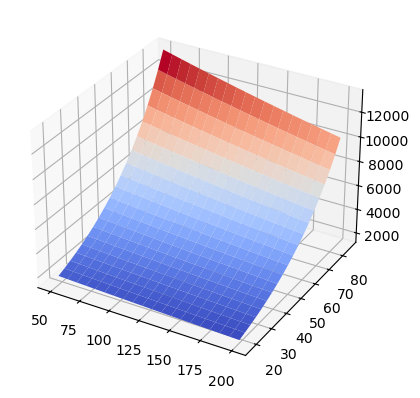

In [42]:
# Desired range and sample points for each feature
x_feat1 = np.linspace(50, 200, 20)
x_feat2 = np.linspace(18, 85, 20)

xv, yv = np.meshgrid(x_feat1, x_feat2)

def ptw_predict(x, y):
    x_data = pd.DataFrame({"BonusMalus": [x], "DrivAge": [y]})
    return res_gamma.predict(exog=x_data)

output = np.empty((len(x_feat1), len(x_feat2)))
for i, xcoord in enumerate(x_feat1):
    for j, ycoord in enumerate(x_feat2):
        output[i, j] = ptw_predict(xcoord, ycoord)

# test_pred = res_gamma.predict(exog=test_avgclaimsev[["BonusMalus", "Density"]])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(xv, yv, output, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Schadenskalkulation und Tarifentwicklung

# Messy prototyping

In [45]:
# statsmodels GAM

# create spline basis for BonusMalus and DrivAge
x_spline = train_avgclaimsev[["BonusMalus", "DrivAge"]]

bs = BSplines(x_spline, df=[10, 10], degree=[3, 3])

gam_bs = GLMGam.from_formula('AvgClaimAmount ~ 1', data=train_avgclaimsev, smoother=bs, family=sm.families.Gamma(link=sm.families.links.Log()))
res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         AvgClaimAmount   No. Observations:                15759
Model:                         GLMGam   Df Residuals:        -8965851308695.13
Model Family:                   Gamma   Df Model:             8965851324453.13
Link Function:                    Log   Scale:                     -3.9577e-08
Method:                         PIRLS   Log-Likelihood:                    nan
Date:                Wed, 02 Oct 2024   Deviance:                       22339.
Time:                        02:00:42   Pearson chi2:                 3.55e+05
No. Iterations:                  1000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.491e+11        nan        nan

C:\Users\marva\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:810: RuntimeWarning: invalid value encountered in log
  ll_obs = weight_scale * np.log(weight_scale * endog_mu)
